In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences


#urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")


total_data = pd.read_csv('./TrainData_total.csv', encoding='cp949')
total_data.drop(['Unnamed: 2', 'Unnamed: 3'], axis = 1, inplace = True)
total_data[:5]

,label,reviews
0,2,3년 전이라 기억도 잘 안난다. 아마 소개받아서 만났을 거야.
1,2,반장인 나보다 부반장인 친구가 반 아이들을 더 잘 이끈다는 말을 들어서 속상해. 부...
2,2,올라갔다가 내려갔다가 왔다갔다 했다가. 그랬네요.
3,2,합격할 거라고 생각했던 회사에 떨어지고 나니까 너무 실망스러워서 밥맛도 없어.
4,2,나 면접 또 떨어졌어.


In [25]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(31197, 3)

In [26]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 31197


In [27]:
print(total_data.isnull().values.any())
print(total_data.reviews)

False
0                       3년 전이라 기억도 잘 안난다. 아마 소개받아서 만났을 거야.
1        반장인 나보다 부반장인 친구가 반 아이들을 더 잘 이끈다는 말을 들어서 속상해. 부...
2                              올라갔다가 내려갔다가 왔다갔다 했다가. 그랬네요.
3              합격할 거라고 생각했던 회사에 떨어지고 나니까 너무 실망스러워서 밥맛도 없어.
4                                             나 면접 또 떨어졌어.
                               ...                        
34115    요통으로 집에서 못 나가서 혼자 적적할 때 옆집 김 씨가 놀러 와 줘서 신이 나. ...
34116    나 직장에 합격했어! 가족에게 말했는데 매우 좋아해. 다른 회사도 면접을 봤는데 그...
34117    오늘 발표시간에 내 차례가 되니 눈앞이 캄캄해지는 거 있지. 당황하고 있는데 친구가...
34118                      친구 덕에 신이 나. 친구가 같이 여행을 가자고 했거든.
34119    부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다. 그래서 마음의 안정을 가...
Name: reviews, Length: 31197, dtype: object


훈련 데이터와 테스트 데이터 분리하기

In [28]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 23397
테스트용 리뷰의 개수 : 7800


레이블의 분포 확인

<Axes: >

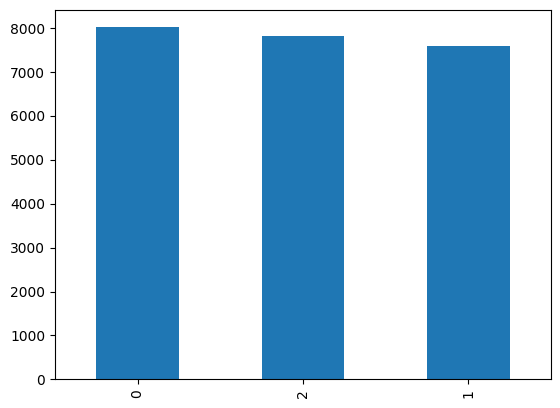

In [29]:
train_data['label'].value_counts().plot(kind = 'bar')

In [30]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   8011
1      1   7580
2      2   7806


데이터 정제하기

In [31]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


<ipython-input-31-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [32]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 7800


<ipython-input-32-5968a3f5f2bc>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [33]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

토큰화

In [34]:
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

단어와 길이 분포 확인하기

In [35]:
negative_words = np.hstack(train_data[train_data.label == 2]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
neutral_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)

In [36]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('어', 5439), ('나', 3841), ('아', 2198), ('는데', 2141), ('너무', 2105), ('내', 1938), ('있', 1716), ('안', 1651), ('해', 1527), ('같', 1451), ('없', 1443), ('것', 1401), ('친구', 1336), ('했', 1260), ('야', 1231), ('겠', 1083), ('않', 978), ('일', 952), ('거', 950), ('말', 797)]


In [37]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('어', 6323), ('아', 2950), ('좋', 2673), ('나', 2400), ('있', 2378), ('해', 2321), ('는데', 2232), ('내', 2186), ('했', 2024), ('너무', 1917), ('야', 1820), ('것', 1563), ('었', 1554), ('같', 1456), ('친구', 1441), ('잘', 1140), ('주', 1101), ('거', 1083), ('정말', 1053), ('일', 1008)]


In [38]:
neutral_word_count = Counter(neutral_words)
print(neutral_word_count.most_common(20))

[('어', 4089), ('아', 1525), ('있', 1414), ('겠', 1152), ('해', 1037), ('나', 1031), ('같', 966), ('거', 856), ('좋', 848), ('것', 753), ('없', 717), ('야', 703), ('는데', 700), ('었', 674), ('친구', 651), ('안', 640), ('좀', 619), ('했', 598), ('너무', 532), ('았', 502)]


긍정 리뷰의 평균 길이 : 20.288522427440633
중립 리뷰의 평균 길이 : 9.315441268256148
부정 리뷰의 평균 길이 : 17.652831155521394


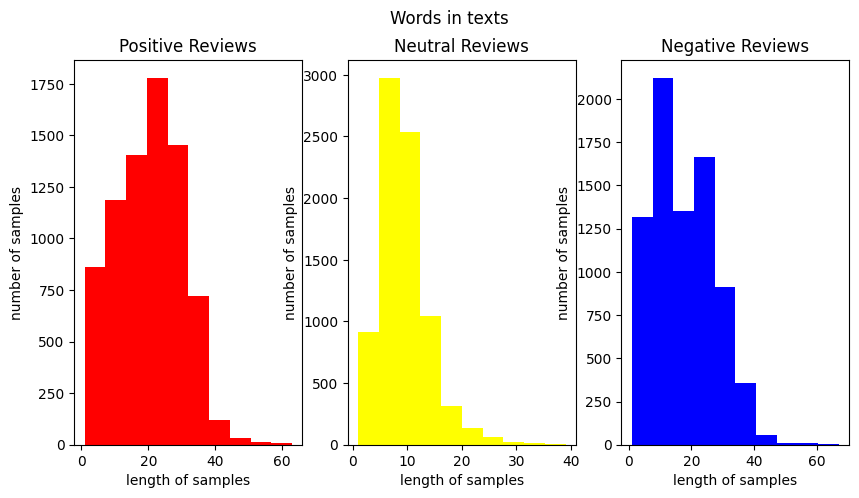

In [39]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
fig.suptitle('Words in texts')
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='yellow')
ax2.set_title('Neutral Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('중립 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==2]['tokenized'].map(lambda x: len(x))
ax3.hist(text_len, color='blue')
ax3.set_title('Negative Reviews')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [62]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

def encoding(input_array):
  new_array = []
  for entry in input_array:
    if entry == 0:
      new_array.append([1,0,0])
    elif entry == 1:
      new_array.append([0,1,0])
    else:
      new_array.append([0,0,1])
  return np.array(new_array)
y_train = encoding(y_train)
y_test = encoding(y_test)

[[0 0 1]
 [0 1 0]
 [0 0 1]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]


정수 인코딩

In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [64]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10817
등장 빈도가 1번 이하인 희귀 단어의 수: 4092
단어 집합에서 희귀 단어의 비율: 37.8293427013035
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1173886092990106


In [65]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6727


In [66]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [67]:
print(X_train[:3])

[[115, 837, 323, 11, 971, 10, 4, 15, 9, 129, 3, 49, 69, 15, 1503, 1249, 2, 115, 837, 622, 14, 9, 749, 290, 129, 186, 2], [1043, 281, 466, 455, 8, 210, 19, 13, 26, 2154], [110, 5, 37, 291, 149, 15, 92, 20, 126, 5, 2]]


In [68]:
print(X_test[:3])

[[3221, 170, 2111, 1905, 46, 10, 4, 2702, 3004, 1224, 22, 867, 71, 2500, 995, 579, 5, 14, 12, 4, 198, 23, 502, 2], [718, 28, 23, 183, 4503, 149, 245, 1357, 23, 578, 26, 86, 38, 354, 956, 1357, 23, 578, 26, 803, 86], [2, 375, 642, 28, 209, 18, 14, 12, 25, 2]]


패딩

리뷰의 최대 길이 : 67
리뷰의 평균 길이 : 15.652049408043766


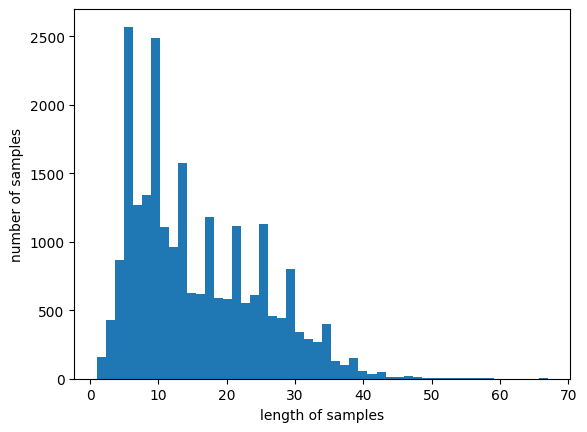

In [69]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [71]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.9786297388554


In [72]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### 감성 분류하기

In [81]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units)) # LSTM 사용
model.add(Dense(3, activation='softmax'))

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=10, validation_split=0.1)

Epoch 1/15
2106/2106 [==============================] - 31s 14ms/step - loss: 0.6371 - accuracy: 0.7249 - val_loss: 0.5103 - val_accuracy: 0.8064
Epoch 2/15
2106/2106 [==============================] - 16s 8ms/step - loss: 0.4890 - accuracy: 0.8067 - val_loss: 0.4860 - val_accuracy: 0.8115
Epoch 3/15
2106/2106 [==============================] - 16s 7ms/step - loss: 0.4519 - accuracy: 0.8237 - val_loss: 0.4737 - val_accuracy: 0.8175
Epoch 4/15
2106/2106 [==============================] - 17s 8ms/step - loss: 0.4233 - accuracy: 0.8340 - val_loss: 0.4749 - val_accuracy: 0.8167
Epoch 5/15
2106/2106 [==============================] - 19s 9ms/step - loss: 0.4013 - accuracy: 0.8452 - val_loss: 0.4868 - val_accuracy: 0.8192
Epoch 6/15
2106/2106 [==============================] - 16s 8ms/step - loss: 0.3842 - accuracy: 0.8531 - val_loss: 0.4794 - val_accuracy: 0.8179
Epoch 7/15
2106/2106 [==============================] - 15s 7ms/step - loss: 0.3693 - accuracy: 0.8604 - val_loss: 0.4883 - val_a

In [82]:
loaded_model = load_model('mocab_lstm.h5')
print("테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

244/244 [==============================] - 2s 5ms/step - loss: 0.7245 - accuracy: 0.7808
테스트 정확도: 0.7808


### 리뷰 예측해보기

In [83]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(model.predict(pad_new))
  #score = model.predict(pad_new) # 예측
  #if(score > 0.5):
  #  print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  #else:
  #  print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [86]:


sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')
sentiment_predict('케릭터가 예뻐서 좋아요')
sentiment_predict('좋아요')
sentiment_predict('싫어요')
sentiment_predict('친구 덕에 신이 나. 친구가 같이 여행을 가자고 했거든.')
sentiment_predict('월급날이야')

1/1 [==============================] - 0s 34ms/step
[[0.48545077 0.17113669 0.34341252]]
1/1 [==============================] - 0s 30ms/step
[[0.6250952  0.37339255 0.00151228]]
1/1 [==============================] - 0s 35ms/step
[[0.589007   0.29167187 0.11932109]]
1/1 [==============================] - 0s 60ms/step
[[0.47067547 0.5130802  0.01624435]]
1/1 [==============================] - 0s 92ms/step
[[0.59643394 0.29254204 0.1110241 ]]
1/1 [==============================] - 0s 46ms/step
[[0.06803949 0.9300207  0.00193985]]
1/1 [==============================] - 0s 44ms/step
[[0.57849175 0.06921652 0.35229173]]
